In [73]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [74]:
#pip install pytorch

In [75]:
#pip install torchvision

In [76]:
#pip install torchsummary

In [77]:
# Location of data
datadir = './dataset/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
#train_on_gpu = cuda.is_available()
#print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
#if train_on_gpu:
#   gpu_count = cuda.device_count()
#   print(f'{gpu_count} gpus detected.')
#   if gpu_count > 1:
#       multi_gpu = True
#   else:
#       multi_gpu = False


In [78]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()
print(cat_df)

,category,n_train,n_valid,n_test
3,severe_dysplastic,177,10,10
1,light_dysplastic,162,10,10
5,carcinoma_in_situ,130,10,10
2,moderate_dysplastic,126,10,10
4,normal_columnar,78,10,10


,category,n_train,n_valid,n_test
5,carcinoma_in_situ,130,10,10
2,moderate_dysplastic,126,10,10
4,normal_columnar,78,10,10
6,normal_superficiel,54,10,10
0,normal_intermediate,50,10,10


              category  n_train  n_valid  n_test
3    severe_dysplastic      177       10      10
1     light_dysplastic      162       10      10
5    carcinoma_in_situ      130       10      10
2  moderate_dysplastic      126       10      10
4      normal_columnar       78       10      10
6   normal_superficiel       54       10      10
0  normal_intermediate       50       10      10


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

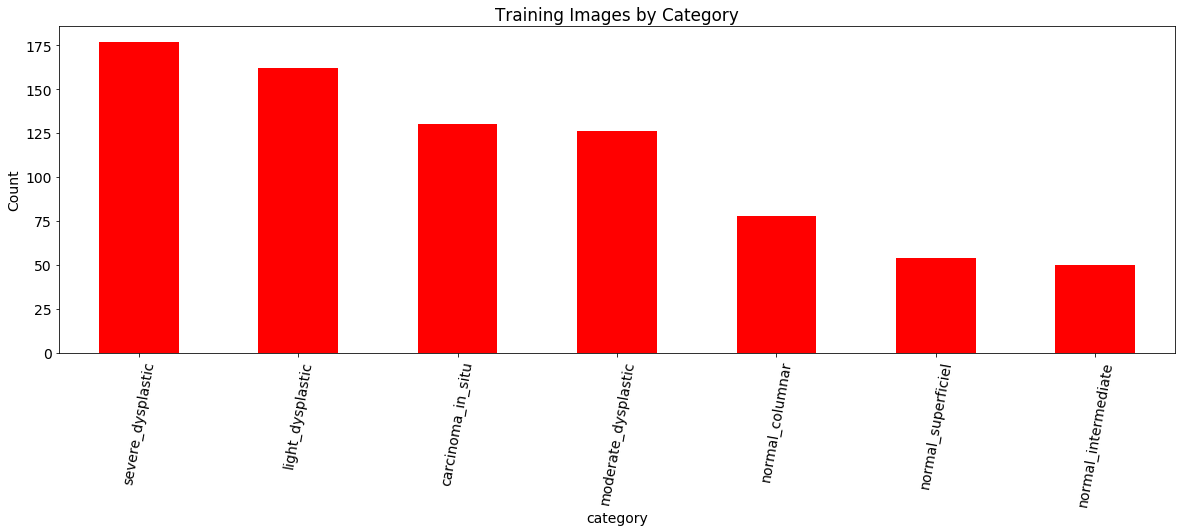

In [79]:

cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [80]:
#img_dsc = image_df.groupby('category').describe()
#img_dsc.head()

(224, 224, 3)

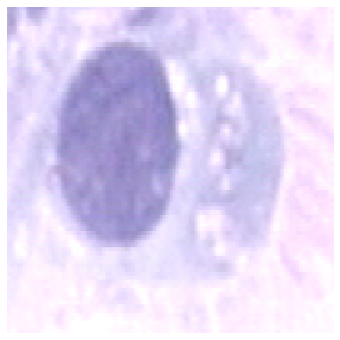

In [81]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(traindir + 'normal_columnar/153956040-153956058-001.BMP')
np.array(x).shape
imshow(x)

In [82]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=(0,90)),
        #transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [83]:

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

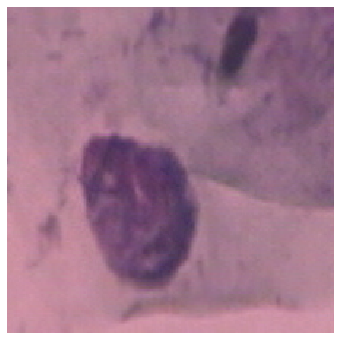

In [84]:
ex_img = Image.open('./dataset/train/light_dysplastic/148498683-148498703-001.BMP')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

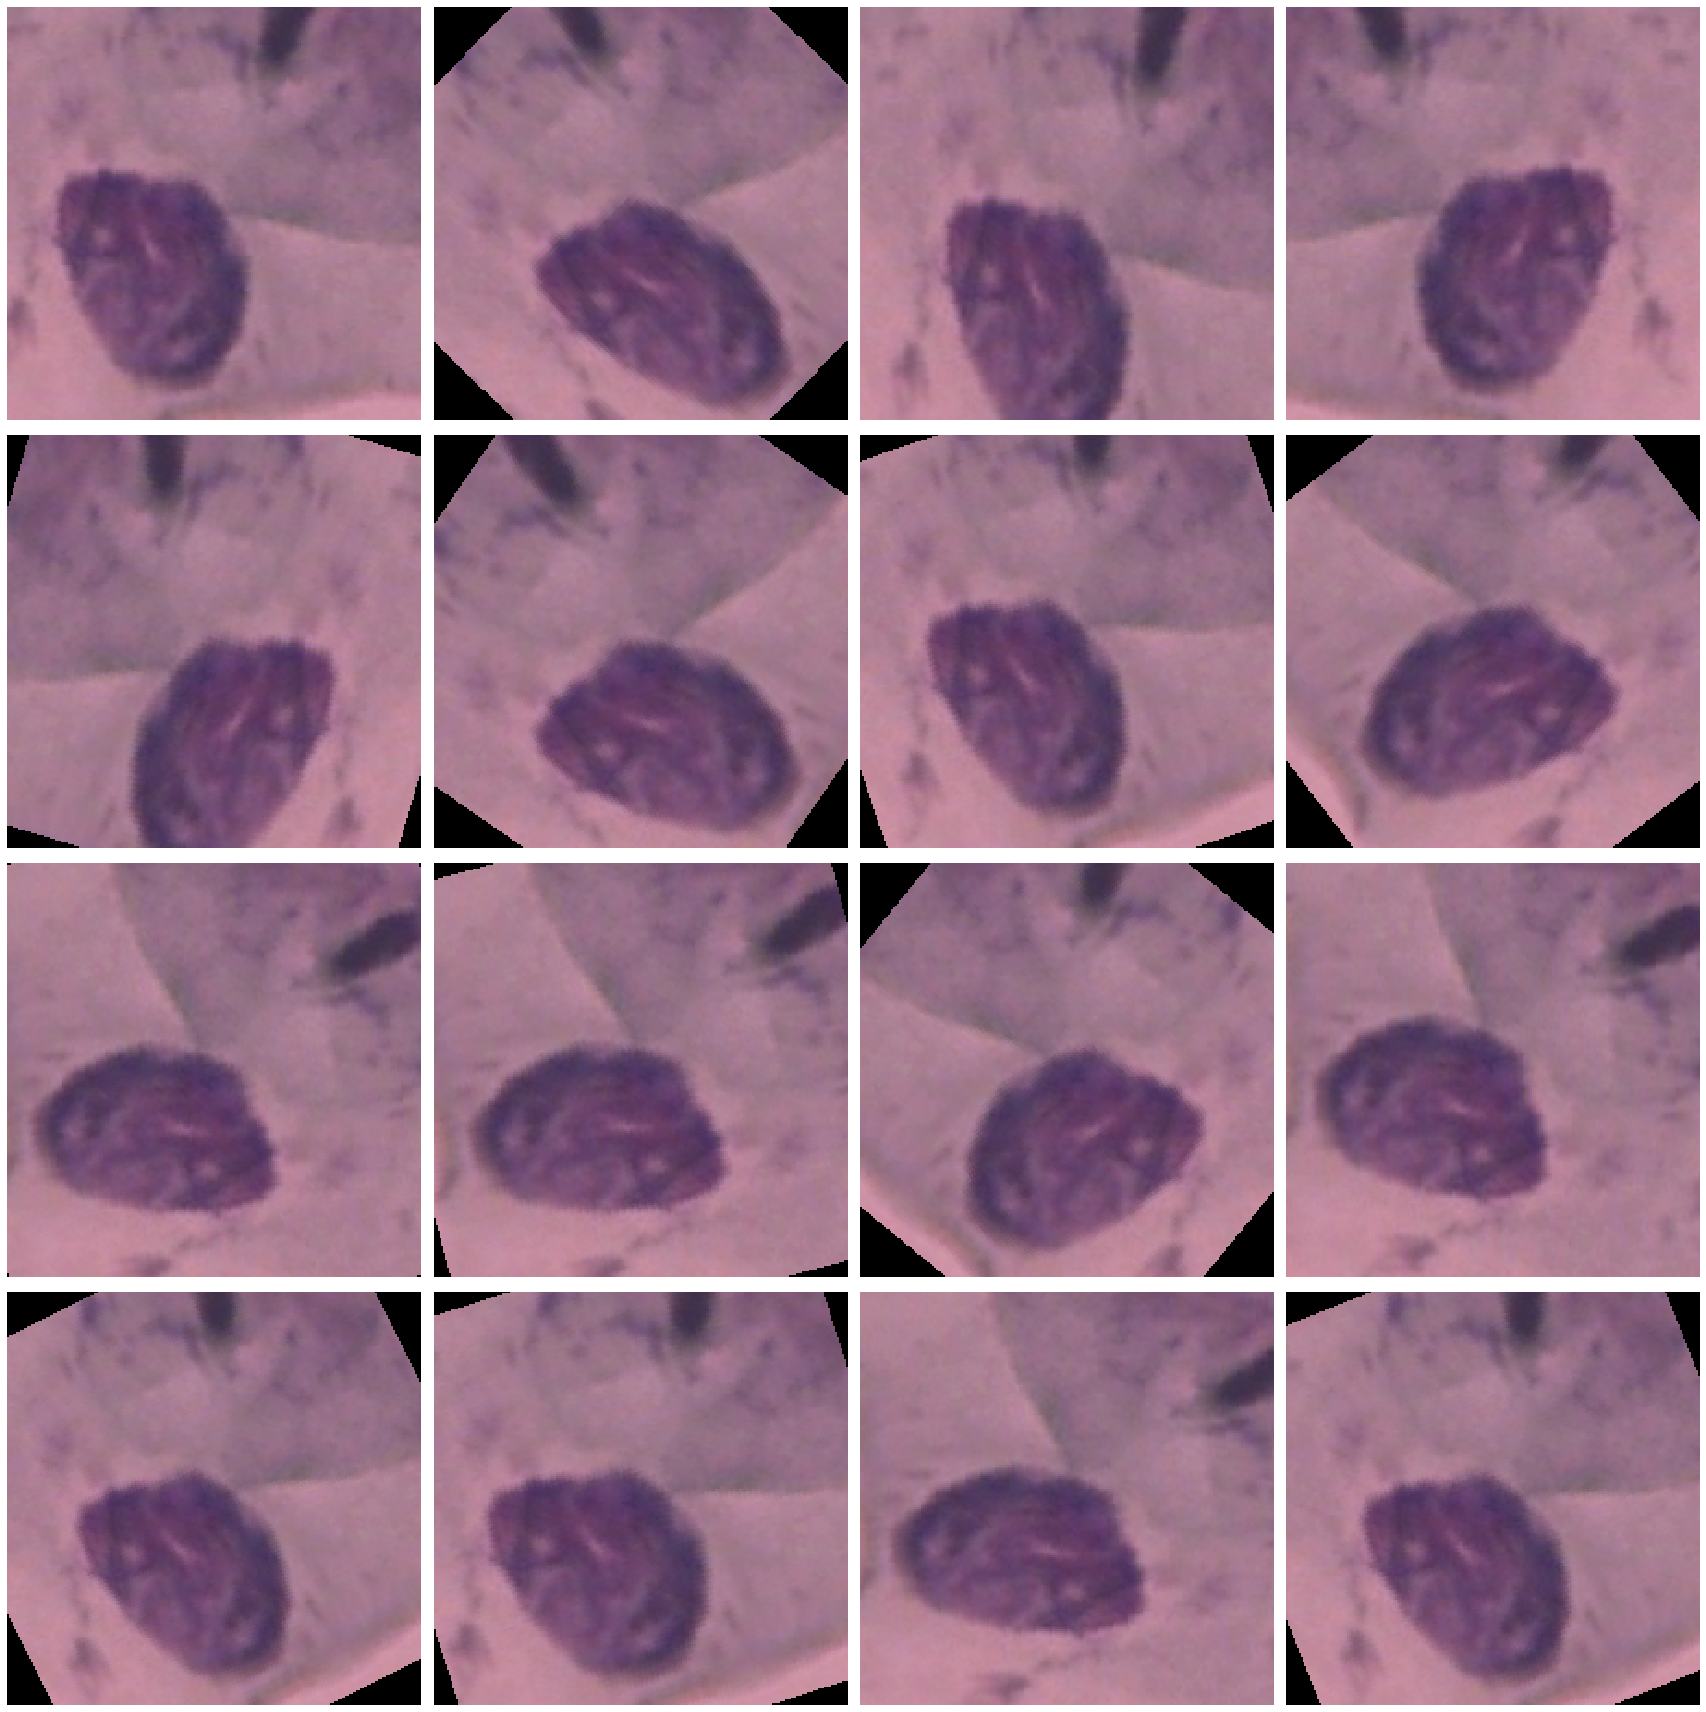

In [85]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [86]:

# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [87]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [88]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 7 different classes.


7

In [89]:

model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [90]:

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [91]:
# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(2048, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=7, bias=True)
  (4): LogSoftmax()
)

In [92]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,034,375 total parameters.
526,343 training parameters.


In [100]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#if train_on_gpu:
model = model.to("cpu")

#if multi_gpu:
#    model = nn.DataParallel(model)

In [93]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    #if train_on_gpu:
    #    model = model.to('cuda')

    #if multi_gpu:
    #    model = nn.DataParallel(model)
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model

In [94]:
model = get_pretrained_model('resnet50')

summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

In [95]:

print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=7, bias=True)
  (4): LogSoftmax()
)


In [96]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'carcinoma_in_situ'),
 (1, 'light_dysplastic'),
 (2, 'moderate_dysplastic'),
 (3, 'normal_columnar'),
 (4, 'normal_intermediate'),
 (5, 'normal_superficiel'),
 (6, 'severe_dysplastic')]

In [97]:

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [98]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([7, 256])
torch.Size([7])


In [31]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            #if train_on_gpu:
            #    data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    #if train_on_gpu:
                    #    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [99]:

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 65.46 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7894 	Validation Loss: 1.8838
		Training Accuracy: 26.64%	 Validation Accuracy: 14.29%
Epoch: 1	100.00% complete. 68.62 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.5467 	Validation Loss: 1.8803
		Training Accuracy: 35.52%	 Validation Accuracy: 28.57%
Epoch: 2	100.00% complete. 66.25 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.4217 	Validation Loss: 1.7739
		Training Accuracy: 44.79%	 Validation Accuracy: 27.14%
Epoch: 3	100.00% complete. 66.25 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.3103 	Validation Loss: 1.7352
		Training Accuracy: 46.33%	 Validation Accuracy: 35.71%
Epoch: 4	100.00% complete. 66.43 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.3460 	Validation Loss: 1.6756
		Training Accuracy: 46.33%	 Validation Accuracy: 41.43%
Epoch: 5	100.00% complete. 67.40 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.2405 	Validation

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

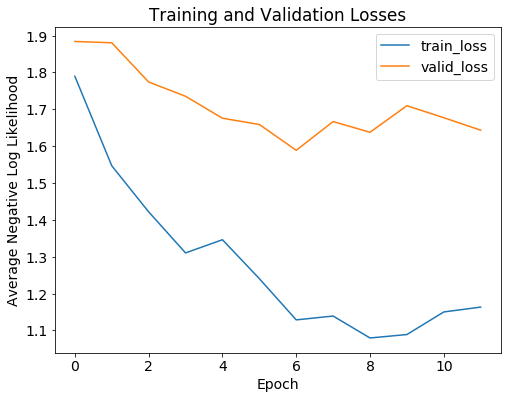

In [101]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

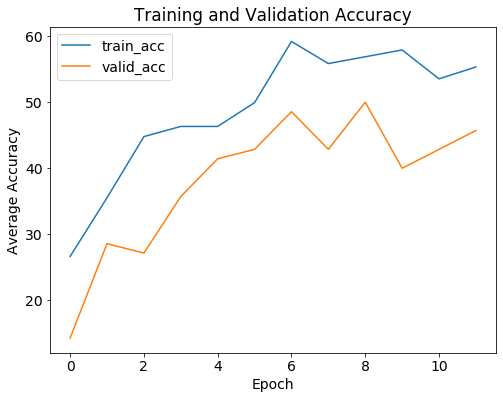

In [102]:

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [103]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    model_name= 'resnet50'
    #model_name = path.split('-')[0]
    #assert (model_name in ['vgg16', 'resnet50'
    #                       ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    #if model_name == 'vgg16':
        # Check to see if model was parallelized
        #if multi_gpu:
        #    checkpoint['classifier'] = model.module.classifier
        #    checkpoint['state_dict'] = model.module.state_dict()
       # else:
         #   checkpoint['classifier'] = model.classifier
         #  checkpoint['state_dict'] = model.state_dict()

    if model_name == 'resnet50':
        #if multi_gpu:
        #    checkpoint['fc'] = model.module.fc
        #    checkpoint['state_dict'] = model.module.state_dict()
        #else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [111]:
save_checkpoint(model, 'resnet.pth')

In [127]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

#     # Get the model name
#     model_name = path.split('-')[0]
#     print(model_name)
#     assert (model_name in ['vgg16', 'resnet50'
#                            ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)
    model_name='resnet50'
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
#     if multi_gpu:
#         model = nn.DataParallel(model)

#     if train_on_gpu:
#         model = model.to('cuda')
    model = model.to('cpu')
    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [128]:

model1, optimizer1 = load_checkpoint('resnet50.pth')
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1=model1.to(device)
#if multi_gpu:
#    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
#else:
#summary(model1, input_size=(3, 224, 224), batch_size=batch_size)

24,034,375 total parameters.
526,343 total gradient parameters.


In [129]:
#summary(model, input_size=(3, 224, 224), batch_size=batch_size)

In [130]:
save_file_name1='resnet.pt'
model, history = train(
    model1,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name1,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1)

Model has been trained for: 12 epochs.

Epoch: 0	100.00% complete. 63.62 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.1031 	Validation Loss: 1.5955
		Training Accuracy: 57.40%	 Validation Accuracy: 47.14%
Epoch: 1	100.00% complete. 68.01 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.1252 	Validation Loss: 1.6062
		Training Accuracy: 55.98%	 Validation Accuracy: 44.29%
Epoch: 2	100.00% complete. 65.55 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.1203 	Validation Loss: 1.6042
		Training Accuracy: 54.31%	 Validation Accuracy: 44.29%
Epoch: 3	100.00% complete. 66.53 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.1184 	Validation Loss: 1.6051
		Training Accuracy: 57.14%	 Validation Accuracy: 47.14%
Epoch: 4	100.00% complete. 65.71 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.1306 	Validation Loss: 1.6150
		Training Accuracy: 55.08%	 Validation Accuracy: 47.14%
Epoch: 5	100.00% complete. 66.40 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.0948 	Val

In [131]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [132]:
x = process_image(testdir + 'severe_dysplastic/153831352-153831372-003.BMP')
x.shape


torch.Size([3, 224, 224])

In [133]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    #if train_on_gpu:
    #    img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
   # else:
    img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [160]:

np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


#_ = imshow_tensor(process_image(random_test_image()))

In [164]:
#img, top_p, top_classes, real_class = predict(random_test_image(), model)
#img.shape

In [165]:

def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

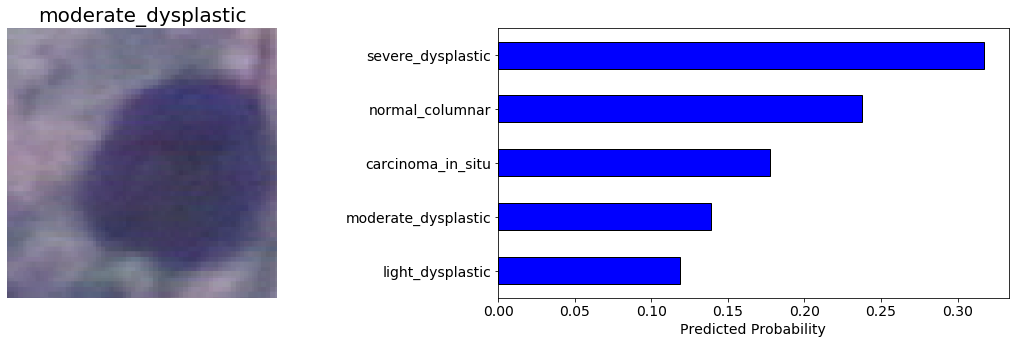

In [180]:

display_prediction(random_test_image(), model, topk=5)